**RNN**
---

`Overview`\
Choose a language model that will best represent the input text.\
Clean and prepare the data for training.\
Build a basic Keras sequential neural network model.\
Apply recurrent neural network (RNN) to process character sequences.\
Generate 3 channel RGB color outputs.

In [2]:
import keras.api._v2.keras as keras

In [15]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape

In [4]:
# We will start with the import of the required packages:

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import *

import numpy as np
import pandas as pd

In [5]:
data = pd.read_csv("colors.csv")
names = data["name"]
data.head()

,name,red,green,blue
0,18th Century Green,165,147,68
1,1975 Earth Red,123,70,59
2,1989 Miami Hotline,221,51,102
3,20000 Leagues Under the Sea,25,25,112
4,3AM in Shibuya,34,85,119


### **Data Preparation**

We mentioned that we’re limiting our color names to 25 characters. To arrive at this number, we checked the distribution of the length of color names across all training samples and visualize it to make sure the length limit we pick makes sense.


AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

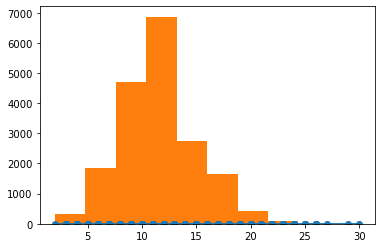

In [6]:
h = sorted(names.str.len().values)
import numpy as np
import scipy.stats as stats
import pylab as plt

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.plot(h,fit,'-o')
plt.hist(h,normed=True)      #use this to draw histogram of your data
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

`That gives us this plot, and you can clearly see that the majority of the color name strings have lengths less or equal to 25, even though the max length goes up to 30.`

In [13]:
# import Tonenizer from keras
from keras.preprocessing.text import Tokenizer
# import pad_sequences from keras
from keras.utils import pad_sequences

In [17]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = pad_sequences(tokenized, maxlen=maxlen)
print(padded_names.shape)

(18606, 25)


`Right now, padded_names will have the shape of (18606, 25), with 18,606 is the number of total training samples and 25 being the max sequence length. If a string has less than 25 characters, it will be padded with the value 0 from the beginning of the sequence.`

You might be thinking, all inputs are now in the form of integers, and our model should be able to process it. But there is one more step we can take to make later model training more effective.

### **One-hot Encoding**

In [18]:
# We can view the character to integer mapping by inspecting the t.word_index property of the instance of Keras’ Tokenizer.
print(t.word_index)

{'e': 1, 'a': 2, ' ': 3, 'r': 4, 'i': 5, 'l': 6, 'n': 7, 'o': 8, 's': 9, 't': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'b': 17, 'm': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'j': 25, 'q': 26, 'x': 27, "'": 28, '-': 29, 'ō': 30, 'è': 31, 'é': 32, 'ā': 33, 'á': 34, 'ó': 35, 'ū': 36, '0': 37, '8': 38, '.': 39, 'ē': 40, 'ī': 41, 'ǎ': 42, '!': 43, 'í': 44, '&': 45, 'ǜ': 46, '9': 47, '2': 48, 'à': 49, 'ǐ': 50, '’': 51, '6': 52, 'ú': 53, '1': 54, '3': 55, 'â': 56, '4': 57, 'ǔ': 58, 'ì': 59, '7': 60, '5': 61, 'ê': 62, 'ö': 63, 'ł': 64, 'š': 65, 'ü': 66, '₂': 67, 'ò': 68, 'ñ': 69, 'ě': 70, 'ń': 71, 'ä': 72, 'œ': 73, 'ß': 74, '%': 75, 'ı': 76, 'ż': 77, '/': 78, 'î': 79, 'ë': 80, '(': 81, ')': 82, 'å': 83, '$': 84, 'я': 85, 'ő': 86, 'ğ': 87, 'ç': 88, 'ù': 89}


`We can see that all of the most frequent characters (letters) are in the top 25. Therefore, this number should be sufficient.`

`However, the integer values have no natural ordered relationship between each other and our model may not be able to harness any benefit from it. What’s worse, our model will initially assume such an ordering relationship among those characters (i.e. “a” is 2 and “e” is 1 but that should not signify a relationship), which can lead to an unwanted result. We will use one-hot encoding to represent the input sequence.`

`Each integer will be represented by a boolean array where only one element in the array will have a value of 1. The max integer value will determine the length of the boolean array in the character dictionary.`

`In our case, the max integer value is 'ù': 89, so the length of a one-hot boolean array will be 28 (considering the lowest value starts with 0, which is the padding).`

`For example, instead of using the integer value 2 to represent character ‘a’, we’re going to use one-hot array [0, 0, 1, 0 …….. 0].`

`One-hot encoding is also accessible in Keras.`

In [19]:
from tensorflow.python.keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)

In [20]:
print (one_hot_names.shape)

(18606, 25, 90)


`The resulting onehotnames has the shape (18606, 25, 90), which stands for (# of training samples, max sequence length, # of unique tokens).`

### **Data Normalization**

`Remember we’re predicting 3 color channel values, each value ranging between 0–255. There is no golden rule for data normalization. Data normalization is purely practical because in practice it could take a model forever to converge if the training data values are spread out too much. A common normalization technique is to scale values to [-1, 1]. In our model, we’re using a ReLu activation function in the last layer. Since ReLu outputs non-negative numbers, we’ll normalize the values to [0, 1].`

In [21]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])

### **Building the Model**

**To build our model we’re going to use two types of neural networks: a feed-forward neural network and a recurrent neural network. The feed-forward neural network is by far the most common type of neural network. In this neural network, the information comes into the input units and flows in one direction through hidden layers until each reaches the output units.**

`In recurrent neural networks, information can flow around in cycles. These networks can remember information for a long time. Recurrent networks are a very natural way to model sequential data. In our specific model, we’re using one of the most powerful recurrent networks named long short term memory (LSTM).`

**The easiest way to build a deep learning model in Keras is to use its sequential API, and we simply connect each of the neural network layers by calling its model.add() function like connecting LEGO bricks.**

In [22]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 90)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [23]:
history = model.fit(one_hot_names, normalized_values,
                    epochs=40,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/40


2023-05-29 23:52:47.793367: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


466/466 [==============================] - 16s 27ms/step - loss: 0.0685 - acc: 0.5761 - val_loss: 0.0643 - val_acc: 0.5975
Epoch 2/40
466/466 [==============================] - 11s 23ms/step - loss: 0.0636 - acc: 0.6212 - val_loss: 0.0611 - val_acc: 0.6174
Epoch 3/40
466/466 [==============================] - 11s 23ms/step - loss: 0.0609 - acc: 0.6393 - val_loss: 0.0607 - val_acc: 0.6037
Epoch 4/40
466/466 [==============================] - 11s 23ms/step - loss: 0.0583 - acc: 0.6344 - val_loss: 0.0593 - val_acc: 0.6096
Epoch 5/40
466/466 [==============================] - 11s 23ms/step - loss: 0.0559 - acc: 0.6377 - val_loss: 0.0567 - val_acc: 0.6265
Epoch 6/40
466/466 [==============================] - 11s 24ms/step - loss: 0.0537 - acc: 0.6429 - val_loss: 0.0554 - val_acc: 0.6255
Epoch 7/40
466/466 [==============================] - 11s 23ms/step - loss: 0.0516 - acc: 0.6433 - val_loss: 0.0554 - val_acc: 0.6161
Epoch 8/40
466/466 [==============================] - 11s 23ms/step - los

### **Generate Colors**

Let’s define some functions to generate and show the color predicted.

`For a color name input, we need to transform it into the same one-hot representation. To achieve this, we tokenize characters to integers with the same tokenizer with which we processed the training data, pad it to the max sequence length of 25, then apply the one-hot encoding to the integer sequence.`

And for the output RGB values, we need to scale it back to 0–255, so we can display them correctly.

In [26]:
# plot a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def scale(n):
    return int(n * 255) 

def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=90)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

`Let’s give the predict() function a try.`

1/1 [==============================] - 0s 21ms/step
forest, R,G,B: 24 75 24


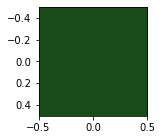

1/1 [==============================] - 0s 29ms/step
ocean, R,G,B: 13 95 154


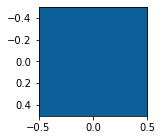

In [33]:
predict("forest")
predict("ocean")